In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('../..')

import modules.pandas_funcs as pf
import analysis.plotting as pl
import analysis.stats as st

In [2]:
results_dir = os.path.join('..', '..', 'data', 'results')
match_dir = os.path.join('..', '..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

In [3]:
df_stacked_k = df_k.groupby(lambda col_name: col_name[:-2], axis=1).apply(lambda x: pd.Series(x.values.flatten('F')))
df_stacked_z = df_z.groupby(lambda col_name: col_name[:-2], axis=1).apply(lambda x: pd.Series(x.values.flatten('F')))

In [4]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.bland_altman(a, b)[0], 
        'Range': lambda a, b: st.bland_altman(a, b)[2] - st.bland_altman(a, b)[1],
        }

In [5]:
df_results = st.compare_measurements(df_k, df_z, funcs)
df_stacked_results = st.compare_measurements(df_stacked_k, df_stacked_z, funcs)

In [6]:
df_stacked_results

,stance_percentage,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.668654,0.912763,0.969071,0.912728,0.943847,0.840251
Spearman,0.688606,0.856471,0.887354,0.675473,0.820698,0.740691
Abs rel error,0.10863,0.0532566,0.0311605,0.167316,0.201086,2.94179
Bias,0.0441908,0.0262082,0.0183009,-0.185143,0.177769,0.37133
Range,0.452486,0.251322,0.153637,0.37684,0.362214,16.8972


## Plotting

In [7]:
plt.rc('text', usetex=True)

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 14,
       }

plt.rc('font', **font)  # pass in the font dict as kwargs

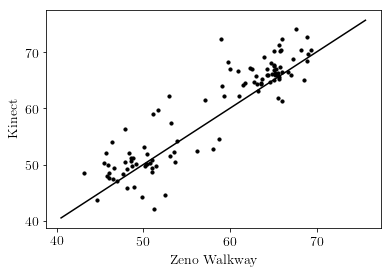

In [8]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
param = 'step_length'
    
pl.compare_measurements(df_stacked_z[param], df_stacked_k[param], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()